In [2]:
# ============================================================================
# Speech Model Embedding Extraction for a Single Audio File
# ============================================================================
# This script demonstrates:
# 1. How to load and prepare a pretrained speech model
# 2. How to process a single audio file
# 3. How to extract both CNN and Transformer embeddings
# 4. How to analyze and visualize the embeddings
# ============================================================================

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from transformers import Wav2Vec2Model, HubertModel, WavLMModel

# ============================================================================
# 1. Model Setup
# ============================================================================
def load_model(model_name, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load a pretrained speech model and prepare it for embedding extraction.

    Args:
        model_name (str): Name of the pretrained model from Hugging Face
        device (str): Device to use ('cuda' or 'cpu')

    Returns:
        model: The loaded model
        model_type (str): Type of the model (wav2vec2, hubert, or wavlm)
    """
    print(f"Loading model {model_name} on {device}...")

    # Determine model type from name
    if "wav2vec2" in model_name:
        model = Wav2Vec2Model.from_pretrained(model_name, output_hidden_states=True)
        model_type = "wav2vec2"
    elif "hubert" in model_name:
        model = HubertModel.from_pretrained(model_name, output_hidden_states=True)
        model_type = "hubert"
    elif "wavlm" in model_name:
        model = WavLMModel.from_pretrained(model_name, output_hidden_states=True)
        model_type = "wavlm"
    else:
        raise ValueError(f"Unsupported model type: {model_name}")

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    return model, model_type

# Processing the audio

In [3]:

# ============================================================================
# 2. Audio Processing
# ============================================================================
def load_and_process_audio(audio_path, target_sr=16000, plot_waveform=True):
    """
    Load an audio file and prepare it for the model.

    Args:
        audio_path (str): Path to the audio file
        target_sr (int): Target sampling rate (16kHz for most speech models)
        plot_waveform (bool): Whether to plot the waveform

    Returns:
        audio (np.array): The loaded audio waveform
        sr (int): The sampling rate
    """
    print(f"Loading and processing audio file: {audio_path}")

    # Load the audio file with librosa
    audio, sr = librosa.load(audio_path, sr=target_sr)

    # Print audio information
    duration = len(audio) / sr
    print(f"Audio duration: {duration:.2f} seconds")
    print(f"Sampling rate: {sr} Hz")
    print(f"Waveform shape: {audio.shape}")

    # Optionally plot the waveform
    if plot_waveform:
        plt.figure(figsize=(10, 3))
        librosa.display.waveshow(audio, sr=sr)
        plt.title("Audio Waveform")
        plt.tight_layout()
        plt.show()

        # Also show spectogram
        plt.figure(figsize=(10, 4))
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Log-frequency power spectrogram')
        plt.tight_layout()
        plt.show()

    return audio, sr

# Embedding extractions
- CNN Extraction
- Transformer Embeddings

The audio needs to be converted into tensor and convert to the base dimension. In CNN feature maps, hooks (pytorch) are used, which are used to extract the embeddings.

In [4]:
# ============================================================================
# 3. Embedding Extraction
# ============================================================================
def extract_embeddings(model, audio, model_type, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract CNN and Transformer embeddings from an audio sample.

    Args:
        model: The pretrained speech model
        audio (np.array): Audio waveform
        model_type (str): Type of model (wav2vec2, hubert, or wavlm)
        device (str): Device to use

    Returns:
        cnn_embeddings: List of CNN layer embeddings
        transformer_embeddings: List of Transformer layer embeddings
    """
    print("Extracting embeddings...")

    print(audio.shape)
    # Convert audio to tensor and add batch dimension
    input_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).to(device)
    print(input_tensor.shape)


    # Define the input dict for the model
    inputs = {"input_values": input_tensor}

    # ========== Extract CNN embeddings ==========
    # We use hooks to capture outputs from CNN layers
    cnn_outputs = {}
    hooks = []

    # Register forward hooks on CNN layers
    for i, layer in enumerate(model.feature_extractor.conv_layers):
        def get_hook(idx):
            def hook(module, input, output):
                cnn_outputs[idx] = output.detach()
            return hook

        handle = layer.register_forward_hook(get_hook(i))
        hooks.append(handle)

    with torch.no_grad():
        outputs = model(**inputs)

    # Get transformer embeddings from model output
    transformer_embeddings = outputs.hidden_states

    # Remove the hooks
    for handle in hooks:
        handle.remove()

    # Organize CNN embeddings by layer order
    cnn_embeddings = [cnn_outputs[i] for i in sorted(cnn_outputs.keys())]

    # Print embedding information
    print("\nEmbedding Information:")
    print("=====================")

    print("\nCNN Embeddings:")
    for i, emb in enumerate(cnn_embeddings):
        print(f"  Layer {i}: Shape = {emb.shape}")

    print("\nTransformer Embeddings:")
    for i, emb in enumerate(transformer_embeddings):
        print(f"  Layer {i}: Shape = {emb.shape}")

    return cnn_embeddings, transformer_embeddings

In [5]:
# ============================================================================
# 4. Embedding Analysis and Visualization
# ============================================================================
def analyze_embeddings(cnn_embeddings, transformer_embeddings):
    """
    Analyze and visualize the extracted embeddings.

    Args:
        cnn_embeddings: List of CNN layer embeddings
        transformer_embeddings: List of Transformer layer embeddings
    """
    print("\nAnalyzing embeddings...")

    # ========== Convert embeddings to numpy ==========
    # Move to CPU and convert to numpy for analysis
    cnn_numpy = [emb.cpu().numpy() for emb in cnn_embeddings]
    transformer_numpy = [emb.cpu().numpy() for emb in transformer_embeddings]

    print("\nNumPy Embedding Information:")
    print("===========================")

    print("\nCNN Embeddings (NumPy):")
    for i, emb in enumerate(cnn_numpy):
        print(f"  Layer {i}: Shape = {emb.shape}, Data type = {emb.dtype}")
        # Show basic statistics
        print(f"    Min: {emb.min():.4f}, Max: {emb.max():.4f}, Mean: {emb.mean():.4f}, Std: {emb.std():.4f}")

    print("\nTransformer Embeddings (NumPy):")
    for i, emb in enumerate(transformer_numpy):
        print(f"  Layer {i}: Shape = {emb.shape}, Data type = {emb.dtype}")
        # Show basic statistics
        print(f"    Min: {emb.min():.4f}, Max: {emb.max():.4f}, Mean: {emb.mean():.4f}, Std: {emb.std():.4f}")

    # ========== Visualize embeddings ==========
    # For CNN - we'll visualize the average feature activation over time
    plt.figure(figsize=(12, 8))

    # Visualize CNN features for a selected layer (last CNN layer)
    selected_cnn_layer = -1
    cnn_features = cnn_numpy[selected_cnn_layer][0]  # First batch

    # Normalize features for visualization
    cnn_features = (cnn_features - cnn_features.min()) / (cnn_features.max() - cnn_features.min())

    plt.subplot(2, 1, 1)
    plt.imshow(cnn_features, aspect='auto', origin='lower')
    plt.colorbar(label='Normalized Activation')
    plt.title(f'CNN Layer {selected_cnn_layer} Features Over Time')
    plt.xlabel('Time Frame')
    plt.ylabel('Feature Channel')

    # Visualize a few transformer features for a selected layer (last transformer layer)
    selected_transformer_layer = -1
    transformer_features = transformer_numpy[selected_transformer_layer][0]  # First batch

    # Take a subset of features for clarity
    feature_subset = transformer_features[:, :50]  # First 50 features

    # Normalize features for visualization
    feature_subset = (feature_subset - feature_subset.min()) / (feature_subset.max() - feature_subset.min())

    plt.subplot(2, 1, 2)
    plt.imshow(feature_subset, aspect='auto', origin='lower')
    plt.colorbar(label='Normalized Activation')
    plt.title(f'Transformer Layer {selected_transformer_layer} Features (Subset) Over Time')
    plt.xlabel('Feature Dimension (first 50)')
    plt.ylabel('Time Frame')

    plt.tight_layout()
    plt.show()

    # Return the numpy arrays for further analysis
    return cnn_numpy, transformer_numpy

In [6]:
def print_cnn_embeddings_shape(cnn_outputs):
    """
    Prints the shapes of CNN embeddings from the Wav2Vec 2.0 feature extractor.

    Parameters:
    cnn_outputs (dict): Dictionary containing CNN layer outputs, indexed by layer number.
    """

    print("\n=== CNN Embeddings ===\n")
    print(f"{'Layer':<10}{'Output Shape':<30}{'Description'}")
    print("=" * 70)

    for layer_idx, output in cnn_outputs.items():
        shape = output.shape  # Expected format: (batch_size, channels, time_steps)
        batch_size, num_channels, time_steps = shape

        description = (
            "Raw feature extraction" if layer_idx == 0 else
            "Further downsampled" if layer_idx < max(cnn_outputs.keys()) else
            "Final compressed representation"
        )

        print(f"{layer_idx:<10}{str(shape):<30}{description}")

    print("\nNote: Time steps decrease as the layers go deeper due to CNN downsampling.")

# Embedding Processing
Take average in temporal dimension (768 dimesion). The whole audio is squezed into 768 dimension vector. So for each layer I am getting 1 embedding of 768 dimension. Similarly for CNN we get 512 vector dimension. 

Here we are taking average, but we can max etc. This is also dependendent on the task to do.

In [7]:
# ============================================================================
# 5. Generate Global Representations
# ============================================================================
def get_global_representations(cnn_embeddings, transformer_embeddings):
    """
    Convert sequence embeddings to fixed-length global representations.

    Args:
        cnn_embeddings: List of CNN embeddings tensors
        transformer_embeddings: List of transformer embeddings tensors

    Returns:
        cnn_global: List of global CNN embeddings (NumPy arrays)
        transformer_global: List of global transformer embeddings (NumPy arrays)
    """
    print("\nGenerating global representations...")

    # Initialize lists to store global representations
    cnn_global = []
    transformer_global = []

    # Process CNN embeddings
    # Shape: (batch, channels, time) -> (batch, channels)
    for i, emb in enumerate(cnn_embeddings):
        # Mean pooling over time dimension (dim=2)
        global_emb = emb.mean(dim=2).cpu().numpy()
        cnn_global.append(global_emb)
        print(f"CNN Layer {i} global shape: {global_emb.shape}")

    # Process transformer embeddings
    # Shape: (batch, time, features) -> (batch, features)
    for i, emb in enumerate(transformer_embeddings):
        # Mean pooling over time dimension (dim=1)
        global_emb = emb.mean(dim=1).cpu().numpy()
        transformer_global.append(global_emb)
        print(f"Transformer Layer {i} global shape: {global_emb.shape}")

    return cnn_global, transformer_global

# Loading the wav2vec2 base model

In [8]:
"""
Main function to demonstrate the embedding extraction process.
"""
# You can choose between different models:
# - "facebook/wav2vec2-base-960h"
# - "facebook/hubert-base-ls960"
# - "microsoft/wavlm-base"
model_name = "facebook/wav2vec2-base"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Load the model
model, model_type = load_model(model_name, device)

Using device: cpu
Loading model facebook/wav2vec2-base on cpu...


# Embedding Extraction
The embeddings are extrcted and analysed.
- In CNN it downsamples the audio because speech has huge number of samples Layer 0 [512 * 6197] - Layer 6 [512 * 96]
- The transformer uses the ouput of the CNN in Layer0 [96 * 768] - Layer 12 [96 * 768]
- 96 is the temporal dimension and 768 is the embedding dimension

Loading and processing audio file: emotions/calm/wavs/Calm-110.wav
Audio duration: 1.94 seconds
Sampling rate: 16000 Hz
Waveform shape: (30993,)


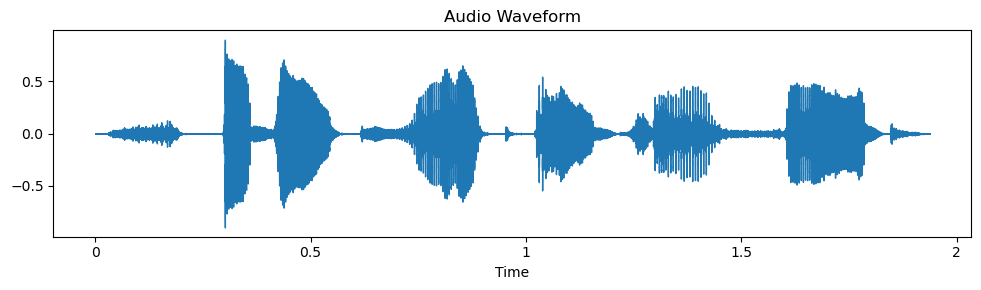

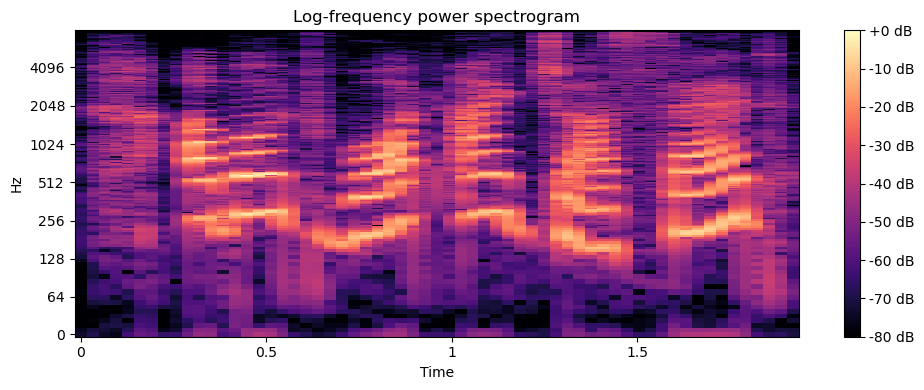

Extracting embeddings...
(30993,)
torch.Size([1, 30993])

Embedding Information:

CNN Embeddings:
  Layer 0: Shape = torch.Size([1, 512, 6197])
  Layer 1: Shape = torch.Size([1, 512, 3098])
  Layer 2: Shape = torch.Size([1, 512, 1548])
  Layer 3: Shape = torch.Size([1, 512, 773])
  Layer 4: Shape = torch.Size([1, 512, 386])
  Layer 5: Shape = torch.Size([1, 512, 193])
  Layer 6: Shape = torch.Size([1, 512, 96])

Transformer Embeddings:
  Layer 0: Shape = torch.Size([1, 96, 768])
  Layer 1: Shape = torch.Size([1, 96, 768])
  Layer 2: Shape = torch.Size([1, 96, 768])
  Layer 3: Shape = torch.Size([1, 96, 768])
  Layer 4: Shape = torch.Size([1, 96, 768])
  Layer 5: Shape = torch.Size([1, 96, 768])
  Layer 6: Shape = torch.Size([1, 96, 768])
  Layer 7: Shape = torch.Size([1, 96, 768])
  Layer 8: Shape = torch.Size([1, 96, 768])
  Layer 9: Shape = torch.Size([1, 96, 768])
  Layer 10: Shape = torch.Size([1, 96, 768])
  Layer 11: Shape = torch.Size([1, 96, 768])
  Layer 12: Shape = torch.Size

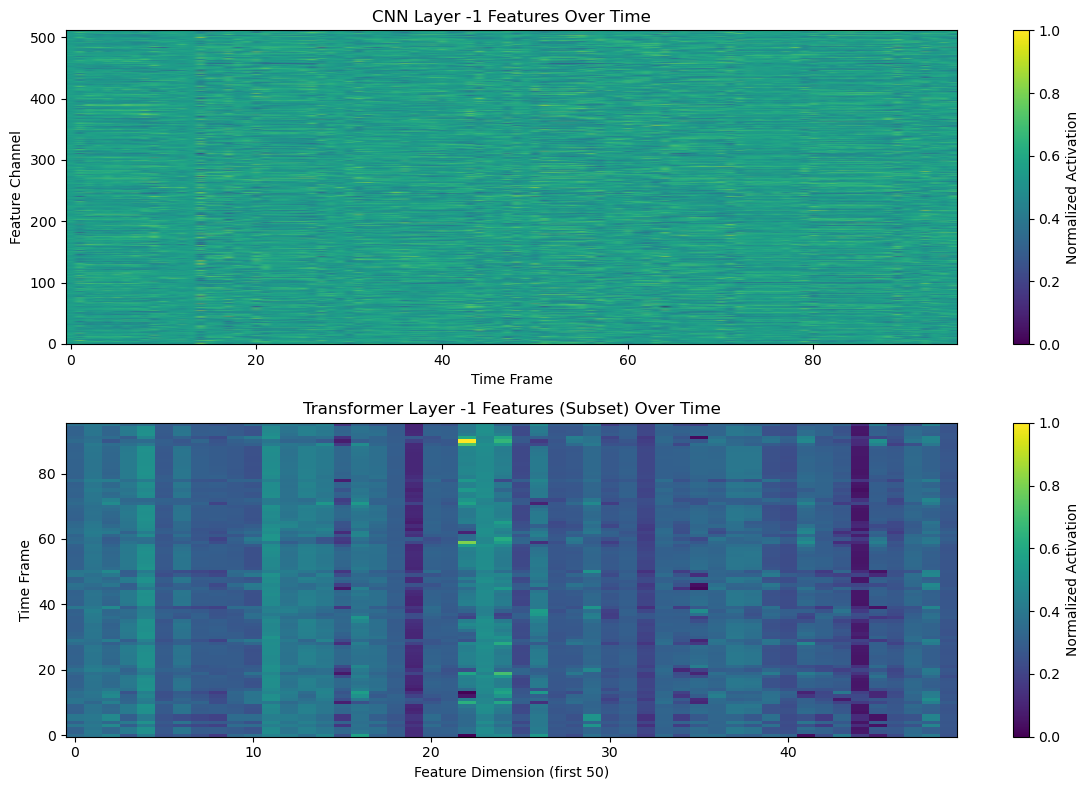


Generating global representations...
CNN Layer 0 global shape: (1, 512)
CNN Layer 1 global shape: (1, 512)
CNN Layer 2 global shape: (1, 512)
CNN Layer 3 global shape: (1, 512)
CNN Layer 4 global shape: (1, 512)
CNN Layer 5 global shape: (1, 512)
CNN Layer 6 global shape: (1, 512)
Transformer Layer 0 global shape: (1, 768)
Transformer Layer 1 global shape: (1, 768)
Transformer Layer 2 global shape: (1, 768)
Transformer Layer 3 global shape: (1, 768)
Transformer Layer 4 global shape: (1, 768)
Transformer Layer 5 global shape: (1, 768)
Transformer Layer 6 global shape: (1, 768)
Transformer Layer 7 global shape: (1, 768)
Transformer Layer 8 global shape: (1, 768)
Transformer Layer 9 global shape: (1, 768)
Transformer Layer 10 global shape: (1, 768)
Transformer Layer 11 global shape: (1, 768)
Transformer Layer 12 global shape: (1, 768)

=== CNN Embeddings ===

Layer     Output Shape                  Description
0         torch.Size([1, 512, 6197])    Raw feature extraction
1         torch

In [10]:
# Step 2: Load and process an audio file
# Replace with the path to your audio file
audio_path = "emotions/calm/wavs/Calm-110.wav"  # Update this path
audio, sr = load_and_process_audio(audio_path)

# Step 3: Extract embeddings
cnn_embeddings, transformer_embeddings = extract_embeddings(model, audio, model_type, device)

# Step 4: Analyze the embeddings
cnn_numpy, transformer_numpy = analyze_embeddings(cnn_embeddings, transformer_embeddings)

# Step 5: Get global representations
cnn_global, transformer_global = get_global_representations(cnn_embeddings, transformer_embeddings)

# Example dictionary of extracted CNN feature maps
cnn_outputs = {
    0: torch.zeros(1, 512, 6197),
    1: torch.zeros(1, 512, 3098),
    2: torch.zeros(1, 512, 1548),
    3: torch.zeros(1, 512, 773),
    4: torch.zeros(1, 512, 386),
    5: torch.zeros(1, 512, 193),
    6: torch.zeros(1, 512, 96),
}

# Call the function to print CNN embedding details
print_cnn_embeddings_shape(cnn_outputs)

# Summary
Time directions - 96 frames, Feature Dimension - 768. Now processing can happen in 2 ways
- Take the embeddings. Then use some model like LSTM -> Downstream tasks
- Take average in temporal dimension (768 dimesion). The whole audio is squezed into 768 dimension vector. So for each layer I am getting 1 embedding of 768 dimension. Similarly for CNN we get 512 vector dimension